Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5244, 3082, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [62]:
#data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(8, 4), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 8 and skip_window = 4:
    batch: ['term', 'term', 'term', 'term', 'term', 'term', 'term', 'term']
    labels: ['first', 'abuse', 'originated', 'used', 'a', 'anarchism', 'of', 'as']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'originated', 'term', 'of', 'as', 'term', 'originated']


Train a skip-gram model.

In [63]:
data_index = 0

batch_size = 128
embedding_size = 200 # Dimension of the embedding vector.
skip_window = 4 # How many words to consider left and right.
num_skips = 8 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [64]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l, = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings_skipgram = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.630477
Nearest to by: setbacks, piro, jamal, plotting, dogmas, deployments, developing, fresh,
Nearest to they: dinaric, titian, sprawling, gable, ulcers, auschwitz, sterile, sotho,
Nearest to first: fora, br, populate, xenon, reliance, folsom, appleby, scat,
Nearest to while: kaplan, backpack, sunrise, amiga, meissen, negotiated, motorways, signet,
Nearest to are: catalans, housman, bellamy, libyans, emiliano, hellenized, supposed, damping,
Nearest to between: prominence, steamboat, saddened, isomer, cunningham, banyan, sedgwick, matre,
Nearest to nine: subdivisions, hanse, good, laine, producing, firth, ecs, ifad,
Nearest to for: ufo, determinant, mcgee, unknown, fertility, yeast, amathus, falsificationism,
Nearest to a: intimacy, lucian, disadvantage, veracruz, carlo, mathfrak, yeager, oscillating,
Nearest to as: ducati, alamein, methylene, storybook, oromo, sequential, lollardy, embargo,
Nearest to over: hong, transmitting, lobby, murdoch, vdp,

Average loss at step 52000: 3.829321
Average loss at step 54000: 3.895667
Average loss at step 56000: 3.851055
Average loss at step 58000: 3.836747
Average loss at step 60000: 3.846861
Nearest to by: with, from, UNK, who, and, during, min, gasolines,
Nearest to they: their, it, to, people, these, heap, not, he,
Nearest to first: game, second, same, after, where, ararat, left, port,
Nearest to while: partements, maturity, kaplan, dwellings, negatives, phyla, roderick, amber,
Nearest to are: were, is, have, many, factoring, some, in, these,
Nearest to between: from, grosso, for, lira, in, colour, harding, devourer,
Nearest to nine: eight, one, seven, six, five, four, three, two,
Nearest to for: in, with, langley, on, between, from, gave, lindy,
Nearest to a: the, an, consumerism, and, blame, annealing, holders, herzl,
Nearest to as: palmas, annoyance, are, bianchi, victors, dura, monoid, grim,
Nearest to over: wig, during, classifies, paranthropus, westwards, turbo, originals, archbishop

In [65]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings_skipgram[1:num_points+1, :])

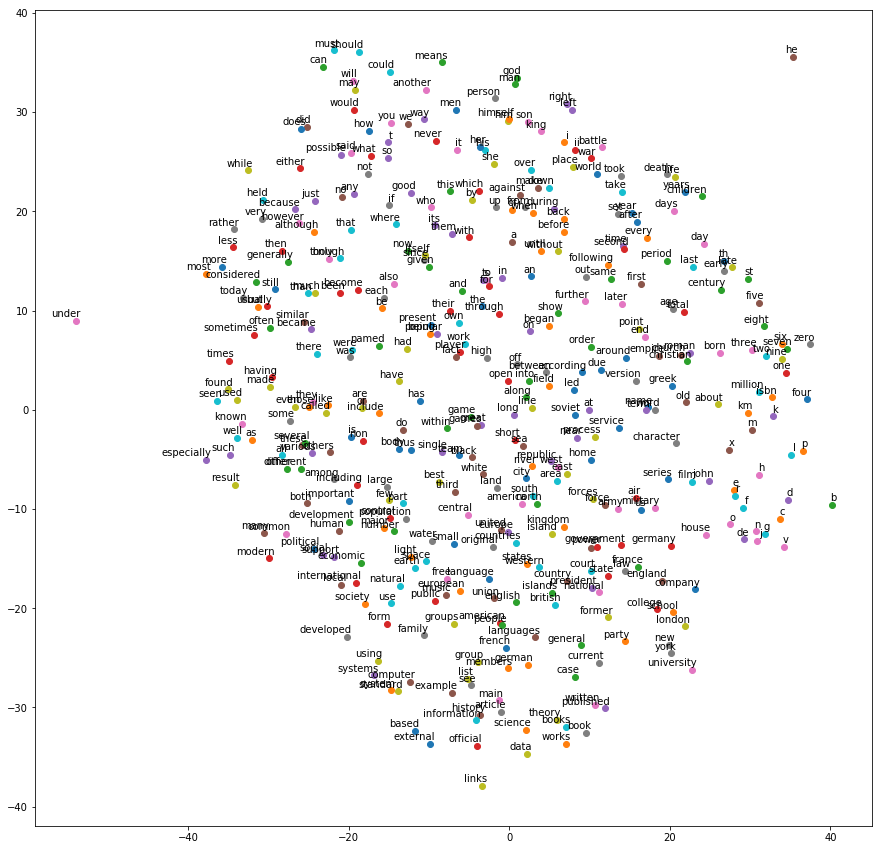

In [66]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [69]:
data_index = 0

def generate_batch(batch_size, window_size):
    global data_index
    span = window_size *2 + 1
    batch = np.ndarray((batch_size , span -1), dtype=np.int32)
    labels = np.ndarray((batch_size , 1), dtype=np.int32)
    
    for i in range(batch_size):
        take_count = span if data_index + span < len(data) else len(data) - data_index - 1
        words = data[data_index: take_count + data_index]
        labels[i, 0] = words[window_size]
        del words[window_size]
        batch[i] = words
        data_index +=1
    return batch, labels
    

In [70]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, window_size=window_size)
    print('\nwith window_size = %d:' % window_size)
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with window_size = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with window_size = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [71]:
data_index = 0

window_size=4

batch_size = 128
embedding_size = 200

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=(batch_size, window_size * 2))
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [72]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, window_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings_cbow = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.648898
Nearest to one: karp, amy, adverbs, stabbed, calabria, tk, left, princess,
Nearest to this: targum, ethnicities, corr, locksmithing, confusion, platypus, disarming, heapsort,
Nearest to and: infrastructures, prod, tet, lincolnshire, agrippina, kushans, anodes, beehive,
Nearest to s: kaczynski, dell, videotape, archer, logographic, salted, henryk, ludwig,
Nearest to only: images, plummeted, indictment, macrobiotic, buick, kg, connects, cedes,
Nearest to see: termini, ez, nibelungenlied, notting, bengali, profitable, accused, canarian,
Nearest to can: pratt, gerhard, unorganized, stenosis, pekka, aslan, cornwell, tilbury,
Nearest to people: coleridge, attar, gardiner, chamada, complains, emphatic, clarity, disunity,
Nearest to often: illusory, curiae, riverine, northern, insults, branch, alvar, shading,
Nearest to i: permittivity, bogomils, burton, futurama, gime, tethys, wend, would,
Nearest to first: nitrites, folks, lothian, penicillin, ins

Average loss at step 52000: 4.162739
Average loss at step 54000: 4.151947
Average loss at step 56000: 4.158347
Average loss at step 58000: 3.874361
Average loss at step 60000: 4.016418
Nearest to one: bc, oda, hogarth, stoughton, eq, incest, mars, broccoli,
Nearest to this: a, the, it, an, another, unknown, whose, what,
Nearest to and: while, or, these, etc, mackintosh, that, which, under,
Nearest to s: his, grenoble, adagio, barge, gepids, its, taxable, two,
Nearest to only: nymph, zamora, brythonic, oases, weldon, starting, encephalopathy, slanted,
Nearest to see: includes, contain, gives, known, saw, wodehouse, lillian, include,
Nearest to can: should, may, must, could, cannot, would, will, might,
Nearest to people: majority, residents, sculptures, speakers, children, jews, townships, those,
Nearest to often: commonly, frequently, usually, generally, dutt, sometimes, traditionally, recordable,
Nearest to i: you, catchers, we, levantine, thy, revamped, albion, bad,
Nearest to first: 

In [73]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings_cbow[1:num_points+1, :])

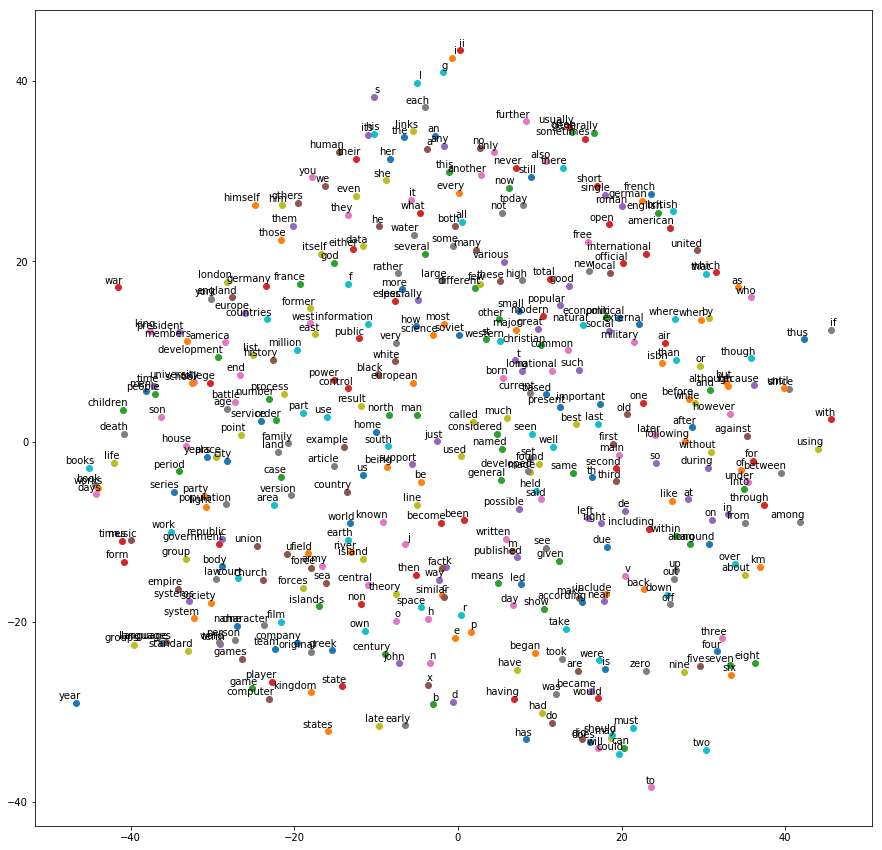

In [74]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [75]:
reverse_dictionary

{0: 'UNK',
 1: 'the',
 2: 'of',
 3: 'and',
 4: 'one',
 5: 'in',
 6: 'a',
 7: 'to',
 8: 'zero',
 9: 'nine',
 10: 'two',
 11: 'is',
 12: 'as',
 13: 'eight',
 14: 'for',
 15: 's',
 16: 'five',
 17: 'three',
 18: 'was',
 19: 'by',
 20: 'that',
 21: 'four',
 22: 'six',
 23: 'seven',
 24: 'with',
 25: 'on',
 26: 'are',
 27: 'it',
 28: 'from',
 29: 'or',
 30: 'his',
 31: 'an',
 32: 'be',
 33: 'this',
 34: 'which',
 35: 'at',
 36: 'he',
 37: 'also',
 38: 'not',
 39: 'have',
 40: 'were',
 41: 'has',
 42: 'but',
 43: 'other',
 44: 'their',
 45: 'its',
 46: 'first',
 47: 'they',
 48: 'some',
 49: 'had',
 50: 'all',
 51: 'more',
 52: 'most',
 53: 'can',
 54: 'been',
 55: 'such',
 56: 'many',
 57: 'who',
 58: 'new',
 59: 'used',
 60: 'there',
 61: 'after',
 62: 'when',
 63: 'into',
 64: 'american',
 65: 'time',
 66: 'these',
 67: 'only',
 68: 'see',
 69: 'may',
 70: 'than',
 71: 'world',
 72: 'i',
 73: 'b',
 74: 'would',
 75: 'd',
 76: 'no',
 77: 'however',
 78: 'between',
 79: 'about',
 80: 'over'

In [101]:
from operator import itemgetter
from prettytable import PrettyTable

def print_similar_words(word_id):
    print('Nearest to "%s":'% reverse_dictionary[word_id])
    embed_colls = [("Skip gram", final_embeddings_skipgram), ("CBOW", final_embeddings_cbow)]
    pt = PrettyTable()
    for embed in embed_colls:
        col = get_similar_items(word_id, embed[1])
        pt.add_column(embed[0],col)
    print(pt)
        
def get_similar_items(word_id, embeddings):
    return get_similar_items_by_vec(embeddings[word_id], embeddings)

def get_similar_items_by_vec(vec, embeddings):
    word_similarities = np.dot(vec, embeddings.T)
    word_similarities_with_idx = list(zip(range(vocabulary_size), word_similarities))
    word_similarities_with_idx.sort(key=itemgetter(1), reverse=True)
    return [reverse_dictionary[i[0]] for i in word_similarities_with_idx[0:11]]

In [102]:
keyword_key_dict = {v: k for k, v in reverse_dictionary.items()}

In [119]:
print_similar_words(keyword_key_dict['italy'])

Nearest to "italy":
+--------------+----------------+
|  Skip gram   |      CBOW      |
+--------------+----------------+
|    italy     |     italy      |
|    france    |     france     |
|  qualifiers  |    germany     |
|     mag      |    androids    |
|     hugh     |      rome      |
|   trainees   | comprehensible |
|  completes   |     detail     |
|  contented   |   babylonia    |
| lamentations |    italian     |
|   hernando   |     litas      |
|   bartlett   |      gad       |
+--------------+----------------+


In [118]:
#skip gram analogy

king_vec = final_embeddings_cbow[keyword_key_dict['paris']]
man_vec = final_embeddings_cbow[keyword_key_dict['france']]

calc_vec = king_vec - man_vec + final_embeddings_cbow[keyword_key_dict['italy']]
get_similar_items_by_vec(calc_vec, final_embeddings_cbow)

['paris',
 'italy',
 'corbusier',
 'bundesland',
 'backtracking',
 'nimitz',
 'bassett',
 'order',
 'space',
 'hamilton',
 'pers']

In [54]:
#cbow analogy

king_vec = final_embeddings_cbow[keyword_key_dict['king']]
man_vec = final_embeddings_cbow[keyword_key_dict['man']]
women_vec = final_embeddings_cbow[keyword_key_dict['female']]

calc_vec = king_vec - man_vec + women_vec
get_similar_items_by_vec(calc_vec, final_embeddings_cbow)

['king',
 'grierson',
 'hitchcock',
 'male',
 'zeitung',
 'malleus',
 'alexander',
 'ban',
 'pageant',
 'laity']